<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum Process Tomography*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q experience (QX), consult the [IBM Q experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Christopher J. Wood

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum process tomography using QISKit, and demonstrate this using both simulators, and the IBM Quantum Experience. This is implemented similarly to [quantum state tomography](state_tomography.ipynb) example notebook [here](state_tomography.ipynb).

The functions used in this notebook to implement state tomography may be imported from the `tools.tomography` module.

#### Experiment Design

The tomography experiments demonstrated in this notebook prepend an arbitrary quantum circuit with preparation and measurements in the Pauli basis. The preparation circuits prepare the system in each of the postive and negative eigenstates of the X, Y, and Z Pauli bases, and the measurement circuits perform state tomography. For $n$-qubits this gives a total of $2^n3^{2n}$ circuits which must be run resulting in a tomographically overcomplete basis for reconstruction of the quantum process.

#### Reconstruction Methods

State reconstruction may be done using a variety of methods. In this notebook implement two simple cases, they are: 
* Least Squares Fitting 
* Fast maximum likelihood (*see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502), open access: [arXiv:1106.5458](https://arxiv.org/abs/1106.5458)*).

Note that while the fast maximum likelihood method constraints the resulting channel to be positive, it does not enfore complete positivity of the final estimate.

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
import numpy as np
    
# importing the QISKit
sys.path.append("../../")
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import tomography libary
import tools.tomography as tomo
from tools.pauli import *

# useful additional packages 
from tools.visualization import plot_state, plot_histogram
from tools.qi import *

from numpy.linalg import norm
# TESTING
from itertools import product, combinations, permutations, combinations_with_replacement

## Process tomography of a Hadamard gate

We will first demonstrate a process tomography experiment for a single qubit H gate.

### Visualization of the ideal process

Plot choi-matrix, rauli

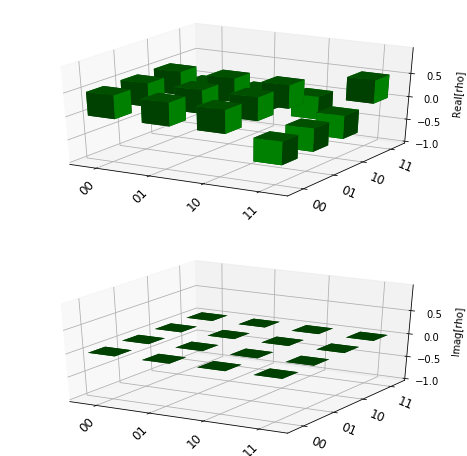

In [2]:
U_had = np.array([[1,1],[1,-1]])/np.sqrt(2)
# compute Choi-matrix from unitary
choi_had = outer(vectorize(U_had))
plot_state(choi_had)

### Creating quantum program for quantum process tomography

Our test circuit simply consists of a quantum program of two qubits with a single gate, the CNOT gate. Note that we must include a two-qubit register to record measurement outcomes.


In [3]:
Q_program = QuantumProgram()
#Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
qr = Q_program.create_quantum_register("qr", 2)
cr = Q_program.create_classical_register("cr", 2)

# hadamard on qubit-0 only
had = Q_program.create_circuit("had", [qr], [cr])
had.h(qr[0])

# quantum circuit to make an entangled bell state 
cnot = Q_program.create_circuit("cnot", [qr], [cr])
cnot.cx(qr[1], qr[0])

Next we build the process tomography circuits (write more later)

In [27]:
backend = 'local_qasm_cpp_simulator'
shots = 1000
tomo_had = tomo.build_process_tomography_circuits(Q_program, 'had', [0], qr, cr)
Q_program.execute(tomo_had, backend=backend, shots=shots)
had_process_data = tomo.process_tomography_data(Q_program, 'had', [0], backend=backend)

>> created process tomography circuits for "had"


### Fitting the tomography data

Process Fidelity =  0.999624615548


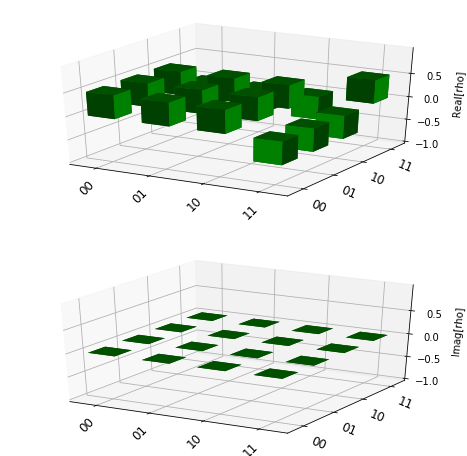

In [30]:
choi_had_fit = tomo.fit_tomography_data(had_process_data, options={'trace':2})
print('Process Fidelity = ', state_fidelity(vectorize(U_had)/2, choi_had_fit))
plot_state(choi_had_fit)


## Process tomography of a CNOT gate

We will demonstrate a process tomography experiment for a CNOT gate.

### Visualization of the ideal process

Plot choi-matrix, rauli

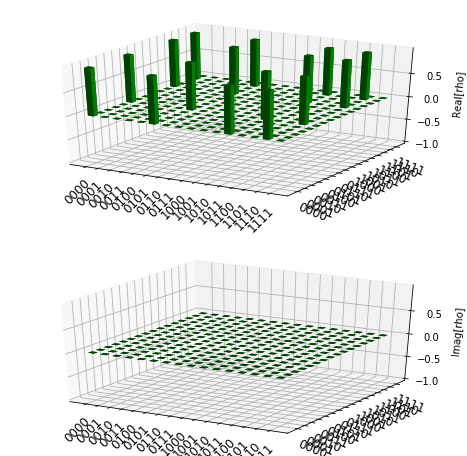

In [7]:
U_cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
# compute Choi-matrix from unitary
choi_cnot = outer(vectorize(U_cnot))
plot_state(choi_cnot) 

### Generating and executing CNOT tomography circuits

Our test circuit simply consists of a quantum program of two qubits with a single gate, the CNOT gate. Note that we must include a two-qubit register to record measurement outcomes.


In [4]:
backend = 'local_qasm_cpp_simulator'
shots = 1000
tomo_cnot = tomo.build_process_tomography_circuits(Q_program, 'cnot', [0,1], qr, cr)
Q_program.execute(tomo_cnot, backend=backend, shots=shots)
cnot_process_data = tomo.process_tomography_data(Q_program, 'cnot', [0,1], backend=backend)

>> created process tomography circuits for "cnot"


Now we fit the data and plot the results

Process Fidelity =  0.999029554356


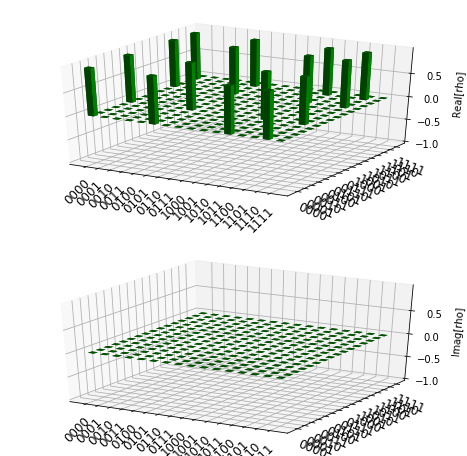

In [8]:
choi_cnot_fit = tomo.fit_tomography_data(cnot_process_data, options={'trace':4})
print('Process Fidelity = ', state_fidelity(vectorize(U_cnot)/4, choi_cnot_fit))
plot_state(choi_cnot_fit)